In [29]:
# Step 1: Data Preprocessing
# Step 2: Implement the Skip-Gram Model
# Step 3: Training the Model
# Step 4: Evaluation

import os
import zipfile
from collections import Counter
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.manifold import TSNE

In [30]:
def download_and_unzip():
    url = "http://mattmahoney.net/dc/text8.zip"
    if not os.path.exists("text8.zip"):
        print("Downloading Text8 Dataset...")
        os.system(f"wget {url}")
    with zipfile.ZipFile("text8.zip", 'r') as zip_ref:
        zip_ref.extractall()
    print("Dataset extracted.")

def preprocess_text():
    with open("text8", 'r') as f:
        text = f.read(20000000)
    words = text.split()
    return words

In [31]:
def build_vocab(words, vocab_size=60000):
    word_counts = Counter(words)

    most_common = word_counts.most_common(vocab_size - 1)

    vocab = {"<UNK>": 0}  # <UNK> tokens for unknown words
    vocab.update({word: idx for idx, (word, _) in enumerate(most_common, start=1)})

    indexed_words = [vocab.get(word, 0) for word in words]

    return vocab, indexed_words

In [32]:
def generate_skip_gram_pairs(indexed_words, window_size=2):
    pairs = []
    for i, center_word in enumerate(indexed_words):
        for j in range(-window_size, window_size + 1):
            if j == 0 or i + j < 0 or i + j >= len(indexed_words):
                continue
            context_word = indexed_words[i + j]
            pairs.append((center_word, context_word))
    return pairs

In [33]:
def unigram_distribution(indexed_words, vocab_size, alpha=0.75):
    word_counts = Counter(indexed_words)
    total_count = sum(word_counts.values())

    unigram_probs = np.zeros(vocab_size)
    for i in range(vocab_size):
        unigram_probs[i] = word_counts[i] / total_count if i in word_counts else 0

    smoothed_probs = unigram_probs ** alpha
    smoothed_probs /= smoothed_probs.sum()

    return smoothed_probs

In [34]:
class SkipGramDataset(Dataset):
    def __init__(self, pairs, negative_sampling_probs, num_negatives=5):
        self.pairs = pairs
        self.negative_sampling_probs = negative_sampling_probs
        self.num_negatives = num_negatives

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        center, context = self.pairs[idx]
        negatives = np.random.choice(
            len(self.negative_sampling_probs),
            size=self.num_negatives,
            p=self.negative_sampling_probs
        )

        return torch.tensor(center), torch.tensor(context), torch.tensor(negatives)

In [35]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.center_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim, sparse=True)

    def forward(self, center, context, negatives):
        center_embeds = self.center_embeddings(center)
        context_embeds = self.context_embeddings(context)
        negative_embeds = self.context_embeddings(negatives)

        pos_score = torch.sum(center_embeds * context_embeds, dim=1)

        neg_score = torch.bmm(negative_embeds, center_embeds.unsqueeze(2)).squeeze(2)

        return pos_score, neg_score

In [38]:
def train_skip_gram_model(pairs, negative_sampling_probs, vocab_size, embedding_dim=100, batch_size=1024, epochs=10):
    dataset = SkipGramDataset(pairs, negative_sampling_probs)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    model = SkipGramModel(vocab_size, embedding_dim).cuda()
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=0.01)
    criterion = nn.BCEWithLogitsLoss()

    scaler = torch.amp.GradScaler()

    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (center, context, negatives) in enumerate(dataloader):
            center = center.cuda()
            context = context.cuda()
            negatives = negatives.cuda()

            optimizer.zero_grad()

            with torch.amp.autocast('cuda'):
                pos_score, neg_score = model(center, context, negatives)

                pos_labels = torch.ones_like(pos_score)  
                neg_labels = torch.zeros_like(neg_score)  

                # calculating loss
                pos_loss = criterion(pos_score, pos_labels)
                neg_loss = criterion(neg_score.view(-1), neg_labels.view(-1))
                loss = pos_loss + neg_loss

            scaler.scale(loss).backward()

            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # print loss every 100 batches
            if batch_idx % 100 == 0:
                print(f"Epoch {epoch + 1}, Batch {batch_idx}, Loss: {loss.item():.4f}")

        print(f"Epoch {epoch + 1} completed with Total Loss: {total_loss:.4f}")

    return model

In [39]:
import time

download_and_unzip()
words = preprocess_text()
vocab, indexed_words = build_vocab(words)
skip_gram_pairs = generate_skip_gram_pairs(indexed_words)
negative_sampling_probs = unigram_distribution(indexed_words, len(vocab))

trained_model = train_skip_gram_model(skip_gram_pairs, negative_sampling_probs, len(vocab))

# to keep session active on google colab
while True:
    pass

Dataset extracted.
Epoch 1, Batch 0, Loss: 11.4015


KeyboardInterrupt: 

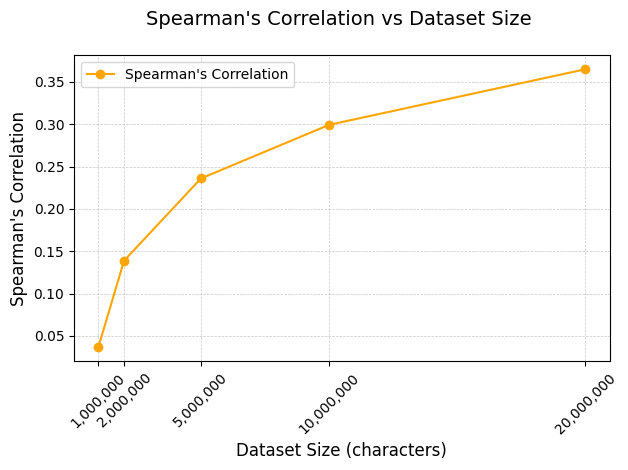

In [51]:
import matplotlib.pyplot as plt

correlation_scores = {1_000_000: 0.0368, 2_000_000: 0.1388, 5_000_000: 0.2360, 10_000_000: 0.2993, 20_000_000: 0.3650}
dataset_sizes = list(correlation_scores.keys())
scores = list(correlation_scores.values())

plt.plot(dataset_sizes, scores, marker='o', linestyle='-', label="Spearman's Correlation", color='orange')
plt.title("Spearman's Correlation vs Dataset Size \n", fontsize=14)
plt.xlabel("Dataset Size (characters)", fontsize=12)
plt.ylabel("Spearman's Correlation", fontsize=12)
plt.xticks(dataset_sizes, [f'{x:,}' for x in dataset_sizes], rotation=45)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()


### **Evaluation**
#### Cosine Similarity Check
- High similarity (>0.7) for synonymous or closely related words.
- Low similarity (<0.3) for unrelated words.

In [ ]:
def check_word_similarity(word1, word2, model, vocab):
    if word1 not in vocab or word2 not in vocab:
        print(f"One or both words ({word1}, {word2}) are not in the vocabulary.")
        return
    embedding_matrix = model.center_embeddings.weight.detach().cpu().numpy()
    vec1 = embedding_matrix[vocab[word1]]
    vec2 = embedding_matrix[vocab[word2]]
    normalized_vec1 = vec1 / np.linalg.norm(vec1)
    normalized_vec2 = vec2 / np.linalg.norm(vec2)
    similarity = np.dot(normalized_vec1, normalized_vec2)
    print(f"Cosine similarity between '{word1}' and '{word2}': {similarity:.4f}")

In [ ]:
check_word_similarity("man", "woman", trained_model, vocab) # example similarity comparison

Cosine similarity between 'man' and 'woman': 0.4718


### Word similarity using *WordSim-353*

In [44]:
def evaluate_word_embeddings(model, vocab, word_sim_file):
    pairs = []
    with open(word_sim_file, 'r') as f:
        next(f)  
        for line in f:
            line = line.strip()
            if not line:
                continue
            try:
                word1, word2, score = line.split(',')
                pairs.append((word1, word2, float(score)))
            except ValueError:
                continue

    model.eval()
    embedding_matrix = model.center_embeddings.weight.detach().cpu().numpy()

    similarities, human_scores = [], []
    for word1, word2, score in pairs:
        if word1 in vocab and word2 in vocab:
            idx1, idx2 = vocab[word1], vocab[word2]
            vec1, vec2 = embedding_matrix[idx1], embedding_matrix[idx2]
            norm1, norm2 = np.linalg.norm(vec1), np.linalg.norm(vec2)

            if norm1 > 0 and norm2 > 0:
                normalized_vec1 = vec1 / norm1
                normalized_vec2 = vec2 / norm2
                similarity = np.dot(normalized_vec1, normalized_vec2)
                similarities.append(similarity)
                human_scores.append(score)

    if similarities and human_scores:
        spearman_corr, _ = spearmanr(similarities, human_scores)
        return spearman_corr
    else:
        return None

In [45]:
evaluate_word_embeddings(trained_model, vocab, 'combined.csv')

NameError: name 'trained_model' is not defined